# 2014 U.S Airline Traffic Data Analysis

## Introduction
This report outlines the findings of 2014 U.S airline traffic data analysis, and perform the supervised machine learning algorithms on the prediction of airline delays in 2015. The remainder of the report is structured as follows: Section I and Section II provide a general exploration of 2014 U.S Airline Traffic Data and Airline Traffic Data of JFK airport respectively. Section III present the process of how we build a model to predict airline delays.

## Load Data and Construct DataFrame

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

import pandas as pd
import numpy as np 
import random
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.cm as cm
from numpy import interp





# merge the csv files of each month for the 2014
out_file = open("2014.csv","a")
with open("2014_unziped//201401.csv","r") as infile_1:
    infile_1.next()   #skip the header
    for line in infile_1:
        out_file.write(line)

for i in range(2,13):
    f = open("2014_unziped//2014"+str(i).zfill(2)+".csv")
    f.next()
    for l in f:
        out_file.write(l)
    f.close()
out_file.close()

In [3]:
col_names = ['YEAR','QUARTER','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','FL_DATE','UNIQUE_CARRIER','AIRLINE_ID',\
            'CARRIER','TAIL_NUM','FL_NUM','ORIGIN_AIRPORT_ID','ORIGIN','ORIGIN_CITY_NAME','ORIGIN_STATE_ABR',\
             'ORIGIN_STATE_NM','DEST_AIRPORT_ID','DEST','DEST_CITY_NAME','DEST_STATE_ABR','DEST_STATE_NM','\
             CRS_DEP_TIME','DEP_TIME','DEP_DELAY','DEP_DEL15','DEP_DELAY_GROUP','TAXI_OUT','TAXI_IN','CRS_ARR_TIME',\
             'ARR_TIME','ARR_DELAY','CANCELLED','CANCELLATION_CODE','DIVERTED','CRS_ELAPSED_TIME','ACTUAL_ELAPSED_TIME',\
             'AIR_TIME','DISTANCE','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY']
chunks = pd.read_csv('2014.csv',chunksize=100000,sep=',',index_col=False,\
                      iterator= True,names=col_names,header=None,parse_dates=['FL_DATE'])

In [6]:
df_2014 = pd.DataFrame()
l=[chunk for chunk in chunks]
df_2014 = pd.concat(l)
df_2014.to_pickle("flt_2014") # # SAVE DATAFRAME BY PICKLE
df_2014.shape # There are 5.3M+ flights in 2014 and 43 attributes 

(5819811, 43)

In [7]:
df_2014 = pd.read_pickle("flt_2014")

In [8]:
#LOAD AIRPORT LOCATION CVS FILE
col_names = ['locationID','Latitude','Longitude']
df_loc = pd.read_csv('Airport_loc.csv',sep=',',index_col=['locationID'],\
                      names=col_names,header=None)
df_loc.head()

,Latitude,Longitude
locationID,,
ADK,51.8781,176.6461
AKK,56.9386,154.1825
Z13,60.9047,161.4225
AKI,60.9028,161.2306
AUK,62.6800,164.6600


## SECTION I.  Analyze nationwide Airline Traffic Data by Airport

### Q1: What are the top 20 busiest US airport in 2014 ?

First, let's look the anual departure-arrival capacity for each airport in the US

In [9]:
# count the number of flights for each airport in USA
df_dpflt = pd.DataFrame(df_2014.groupby(['ORIGIN']).size(),columns=['Total Arrival Flights'])
df_arrflt = pd.DataFrame(df_2014.groupby(['DEST']).size(),columns=['Total Departure Flights'])
df_flt = df_dpflt.join(df_arrflt,how='inner')
# Merge two df_flt and df_loc together based on the airport code
df_fltCount = df_flt.join(df_loc,how='inner')
df_fltCount.to_pickle("df_fltCount")
df_fltCount.sort(['Total Arrival Flights','Total Departure Flights'],ascending=[0,0]).head(n=20)

,Total Arrival Flights,Total Departure Flights,Latitude,Longitude
ATL,369779,369842,33.6367,84.4281
ORD,287036,287377,41.9808,87.9067
DFW,278309,278310,32.8969,97.0381
DEN,224205,224067,39.8617,104.6731
LAX,221932,221941,33.9425,118.4072
IAH,174210,174235,29.9844,95.3414
SFO,166893,166883,37.6189,122.3750
PHX,160475,160466,33.4342,112.0117
LAS,137055,137058,36.0800,115.1522
CLT,112243,112256,35.2139,80.9431


To be more precise, we can look into the hourly arrival-departure capacity for each airport.

In [10]:
df_dpHour = df_2014[['ORIGIN','FL_DATE','DEP_TIME']].dropna(subset=['DEP_TIME'])
df_arrHour =  df_2014[['DEST','ARR_TIME']].dropna(subset=['ARR_TIME'])
df_dpHour['DEP_HOUR'] = df_dpHour['DEP_TIME'].astype(int).astype('str').apply(lambda x: x.zfill(4)[:2])
df_arrHour['ARR_HOUR'] = df_arrHour['ARR_TIME'].astype(int).astype('str').apply(lambda x: x.zfill(4)[:2])

In [11]:
df_dpHourCount = df_dpHour.groupby(['ORIGIN','DEP_HOUR']).size().reset_index()
df_dpHourCount.columns.values[2]='DP_FLT'
#df_dpHourCount.head()

In [12]:
df_arrHourCount = df_arrHour.groupby(['DEST','ARR_HOUR']).size().reset_index()
df_arrHourCount.columns.values[2]='ARR_FLT'
#df_arrHourCount.head()

In [13]:
# Compute the average number of departure flights per hour per day
df_dpAvgHourCount = df_dpHourCount.groupby(['ORIGIN']).mean()
df_dpAvgHourCount['DP_FLT'] =  df_dpAvgHourCount['DP_FLT']/365      
df_dpAvgHourCount.sort(['DP_FLT'],ascending=0).reset_index().head(n=20)

,ORIGIN,DP_FLT
0,ATL,39.886904
1,ORD,31.286644
2,DFW,31.026027
3,DEN,24.249534
4,LAX,24.059397
5,IAH,19.476598
6,SFO,17.832329
7,PHX,17.469918
8,LAS,14.900493
9,CLT,12.602283


In [14]:
# Compute the average number of arrival flights per hour per day
df_arrAvgHourCount = df_arrHourCount.groupby(['DEST']).mean()
df_arrAvgHourCount['ARR_FLT'] =  df_arrAvgHourCount['ARR_FLT']/365      
df_arrAvgHourCount.sort(['ARR_FLT'],ascending=0).reset_index().head(n=20)

,DEST,ARR_FLT
0,ATL,39.814795
1,ORD,29.910247
2,DFW,29.692603
3,DEN,24.169973
4,LAX,24.021589
5,IAH,18.619616
6,SFO,17.790027
7,PHX,17.414575
8,LAS,14.905973
9,CLT,12.061260


### Q2: Delayed Flights Percentage by Airport
Now, let's look into the number of delayed flights for each airport in 2014. We define the notion "delay" as having more than 15min delay, "non-delay" otherwise.  Our "target" variable will be DEP_DEL15(1 if delays of more than 15min,0 otherwise). 

In [15]:
df_delayDpFlt = df_2014[df_2014['DEP_DEL15']==1].groupby(['ORIGIN']).size().to_frame()

In [16]:
df_delayDpFlt.columns = ['DELAY_DEP_FLT'] # delayed departure flights
df_delay = df_fltCount.join(df_delayDpFlt,how='inner').reset_index()

# compute the delayed percentaage
df_delay['Percentage'] = df_delay['DELAY_DEP_FLT']/df_delay['Total Departure Flights']
df_delay.columns.values[0]='Airport'
df_delay.head()

,Airport,Total Arrival Flights,Total Departure Flights,Latitude,Longitude,DELAY_DEP_FLT,Percentage
0,ABE,1638,1641,40.6522,75.4403,204,0.124314
1,ABI,2832,2833,32.4114,99.6819,517,0.182492
2,ABQ,24635,24631,35.0403,106.6092,5643,0.229102
3,ABR,752,751,45.4492,98.4219,59,0.078562
4,ABY,1003,1002,31.5356,84.1944,158,0.157685


In [17]:
# save df_delay
#df_delay.to_pickle("df_delay")

In [18]:
# TOP 20 airports that suffer most severe delaying problems
df_delay.sort(['Percentage'],ascending=0).head(n=20)

,Airport,Total Arrival Flights,Total Departure Flights,Latitude,Longitude,DELAY_DEP_FLT,Percentage
132,GST,77,77,58.4253,135.7075,27,0.350649
228,OTH,376,376,43.4169,124.2469,127,0.337766
57,CEC,963,963,41.7803,124.2367,303,0.314642
192,MDW,88501,88498,41.7861,87.7525,27836,0.314538
142,HOU,59506,59503,29.6456,95.2789,17975,0.302086
9,ADK,104,104,51.8781,176.6461,31,0.298077
81,DAL,48308,48294,32.8472,96.8517,14038,0.290678
225,ORD,287036,287377,41.9808,87.9067,80608,0.280496
136,GUM,365,366,13.4839,144.7972,101,0.275956
51,BWI,90851,90845,39.1753,76.6683,24822,0.273235


Let's combine the airport capacity and delayed percentage together in one plot!

Populating the interactive namespace from numpy and matplotlib


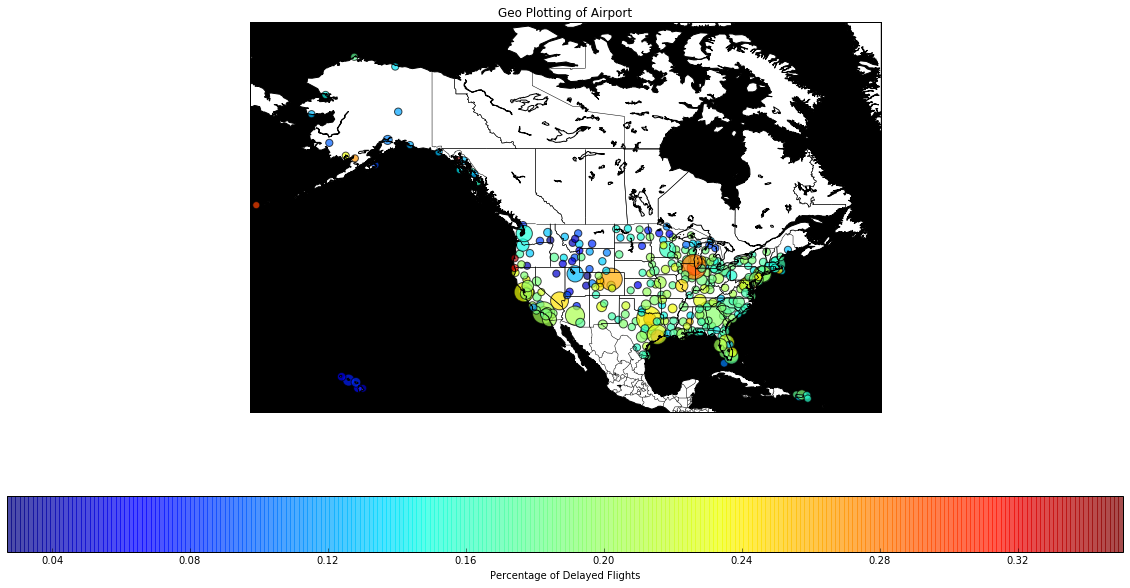

In [19]:
df_delay['Longitude'] = -df_delay['Longitude'] # inverse the longitude

# create markersize array
flt_list = df_delay['Total Arrival Flights'].tolist()
marker_arr = np.array([interp(x,[50,380000],[50,800]) for x in flt_list])

def geo_plot(marker_list):
    m = Basemap(projection='mill',llcrnrlat=15,urcrnrlat=75,\
                llcrnrlon=-178,urcrnrlon=-50,resolution='l',)
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    #m.bluemarble()
    m.drawmapboundary(fill_color='black')
    m.fillcontinents(color='white',lake_color='#FFFFFF',zorder=0)

    lat = df_delay['Latitude'].values
    lon = df_delay['Longitude'].values
    x,y = m(lon,lat)
    m.scatter(x,y, marker='o',s=marker_list,c=df_delay.Percentage,cmap=cm.jet,alpha=0.7)
    cbar = plt.colorbar(orientation="horizontal")
    cbar.ax.set_xlabel('Percentage of Delayed Flights')
    plt.title("Geo Plotting of Airport")
    #plt.figure(figsize=(10,10))
    #plt.savefig('GeoPlot')
    plt.show()

geo_plot(marker_arr)

### Q3: Find the top 10 most connected airports in 2014

To solve this problem, we can directly count the number of pairs of airports in the df_2014 dataframe built above. But there is another way to do this. The solution is to build a airport network. This solution might complicate this problem but it allows people to explore other network problems. 

In [21]:
# Get the number of nodes of the graph
origin = df_2014['ORIGIN'].tolist()
dest = df_2014['DEST'].tolist()
nodes = set(origin+dest)

#get the edges between the nodes
edge_tuples = zip(origin,dest)

# Draw Graph
import networkx as nx
def draw_network(node_list,edge_list):
    G = nx.Graph()
    G.add_nodes_from(node_list)
    for pair in edge_list:
        if G.has_edge(pair[0],pair[1]):
            G[pair[0]][pair[1]]['weight']+=1
        else:
            G.add_edge(pair[0],pair[1],weight=1)
    return G
G = draw_network(nodes,edge_tuples)

In [22]:
# Top 10 the most popular airports in USA 2014
pair_weights = G.edges(data = True)
degree = G.degree(weight='weight')
sorted(degree.items(), key=lambda x: x[1],reverse=True)[:20] # The results is exactly the same as we obtained the top 20 busiest airport. 

[('ATL', 739621),
 ('ORD', 574413),
 ('DFW', 556619),
 ('DEN', 448272),
 ('LAX', 443873),
 ('IAH', 348445),
 ('SFO', 333776),
 ('PHX', 320941),
 ('LAS', 274113),
 ('CLT', 224499),
 ('BOS', 221266),
 ('MCO', 220826),
 ('EWR', 220577),
 ('SEA', 217436),
 ('SLC', 217172),
 ('LGA', 213918),
 ('MSP', 212420),
 ('DTW', 211964),
 ('JFK', 201110),
 ('BWI', 181696)]

Return the top 10 pairs of airports that have the highest number of flights between them

In [23]:
print ("The number of flights is:%d" %len(pair_weights))
print (sorted(pair_weights,key=lambda x: x[2].items()[0][1],reverse=True)[:10])

The number of flights is:2412
[('SFO', 'LAX', {'weight': 26582}), ('JFK', 'LAX', {'weight': 25105}), ('LAX', 'LAS', {'weight': 23199}), ('HNL', 'OGG', {'weight': 19419}), ('ORD', 'LGA', {'weight': 18061}), ('JFK', 'SFO', {'weight': 17887}), ('PHX', 'LAX', {'weight': 17633}), ('ATL', 'LGA', {'weight': 17005}), ('ATL', 'MCO', {'weight': 16875}), ('SAN', 'LAX', {'weight': 16844})]


Visualize the airport network on the map! 

In [24]:
airline = [(x[0],x[1]) for x in pair_weights]
loc_dict = dict(zip(df_delay.Airport,zip(df_delay.Latitude,df_delay.Longitude)))
for node in nodes:
    if node not in loc_dict:
        loc_dict[node]=0,0
origin_loc = [list(loc_dict[pair[0]]) for pair in pair_weights]
dest_loc = [list(loc_dict[pair[1]]) for pair in pair_weights]

merge_loc= [list(x) for x in zip(origin_loc,dest_loc)]
merge_loc_clean =[x for x in merge_loc if x!=[0,0]]

Since there are over 2,000 airlines, it is hard to visualize. We randomly sample 500 airlines to visualize the airport network.  

In [ ]:
sample_loc = np.array([merge_loc_clean[i] \
                       for i in random.sample(range(1, len(merge_loc_clean)), 500)])
lat_y,lon_x = sample_loc.T

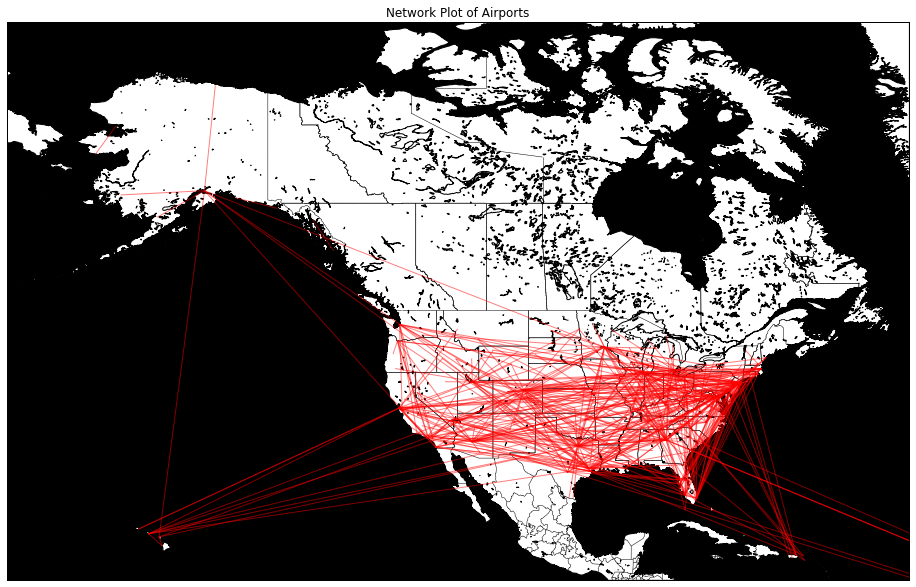

In [26]:
def network_plot(lat,lon):
    m = Basemap(projection='mill',llcrnrlat=15,urcrnrlat=75,\
                llcrnrlon=-178,urcrnrlon=-50,resolution='h',)
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    #m.bluemarble()
    m.drawmapboundary(fill_color='black')
    m.fillcontinents(color='white',lake_color='#FFFFFF',zorder=0)

    x,y = m(lon,lat)
    m.plot(x,y, marker=None,color='red',alpha=0.5)

    plt.title("Network Plot of Airports")
    plt.show()

network_plot(lat_y,lon_x)

### Question 4. Analyze nationwide Airline Traffic Data by Carrier

In [27]:
df_carrier = pd.DataFrame()
df_carrier = df_2014[['UNIQUE_CARRIER','FL_DATE',\
                    'TAIL_NUM','DEP_DELAY','DEP_DEL15']]
#df_carrier.head()

Flight Count by Carrier

In [28]:
df_carrierCount = pd.DataFrame(df_carrier.dropna(subset=['DEP_DELAY']).groupby(['UNIQUE_CARRIER'])\
                    .size(),columns=['FL_COUNT']).reset_index()
df_carrierCount.sort(['FL_COUNT'],ascending=False)

,UNIQUE_CARRIER,FL_COUNT
13,WN,1159661
3,DL,794033
4,EV,652724
9,OO,595643
0,AA,529486
10,UA,486527
11,US,408373
8,MQ,372401
2,B6,243735
1,AS,159568


In [29]:
# compute the number of delayed flights for each airline
df_carrierUpdate = df_carrier.dropna(subset=['DEP_DELAY','DEP_DEL15'])
df_carrierDel = df_carrierUpdate[df_carrierUpdate['DEP_DEL15']==1]
df_carrierDelCount = pd.DataFrame(df_carrierDel.groupby(['UNIQUE_CARRIER'])\
                       .size(),columns=['DEL_COUNT']).reset_index()

In [30]:
df_carrierDelPct = pd.merge(df_carrierDelCount,df_carrierCount,on='UNIQUE_CARRIER',how='inner')
df_carrierDelPct['PERCENT'] = df_carrierDelPct['DEL_COUNT']/df_carrierDelPct['FL_COUNT']*100
df_carrierDelPct

,UNIQUE_CARRIER,DEL_COUNT,FL_COUNT,PERCENT
0,AA,109406,529486,20.662680
1,AS,16607,159568,10.407475
2,B6,49843,243735,20.449669
3,DL,115991,794033,14.607831
4,EV,155334,652724,23.797807
5,F9,18320,85135,21.518764
6,FL,14299,78014,18.328762
7,HA,3782,74585,5.070725
8,MQ,83574,372401,22.441938
9,OO,111354,595643,18.694755


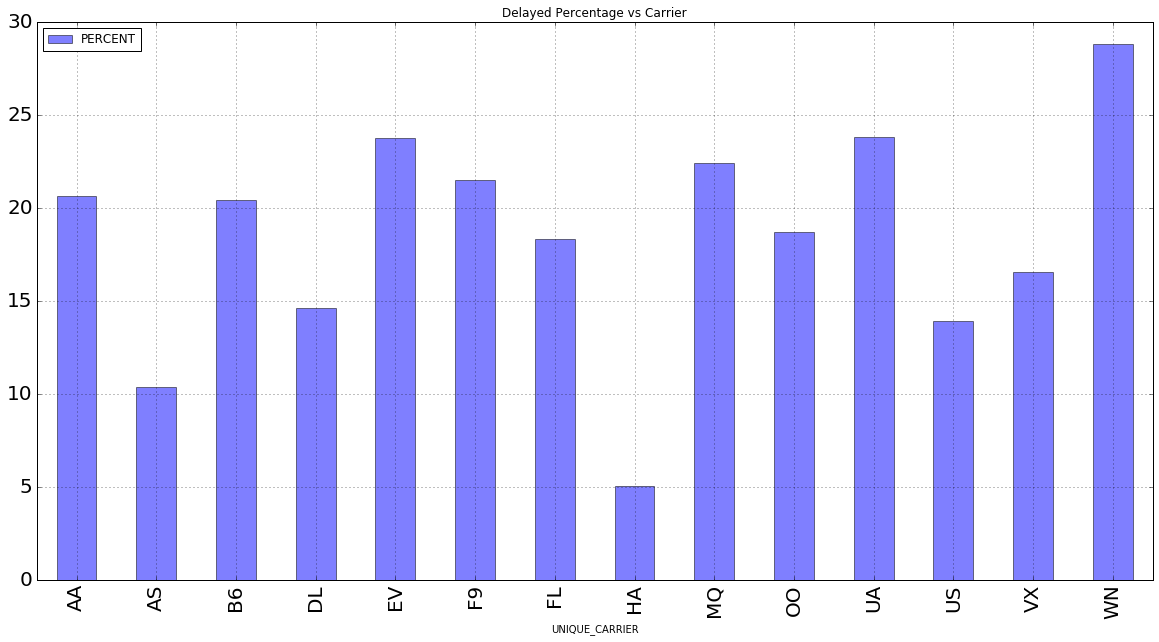

In [31]:
# Plot the percentage of delayed flights by carrier
df_carrierDelPct[['UNIQUE_CARRIER','PERCENT']].plot(x=df_carrierDelPct['UNIQUE_CARRIER'],title='Delayed Percentage vs Carrier',\
                                                    kind='bar',alpha=0.5,grid=True,fontsize =20)

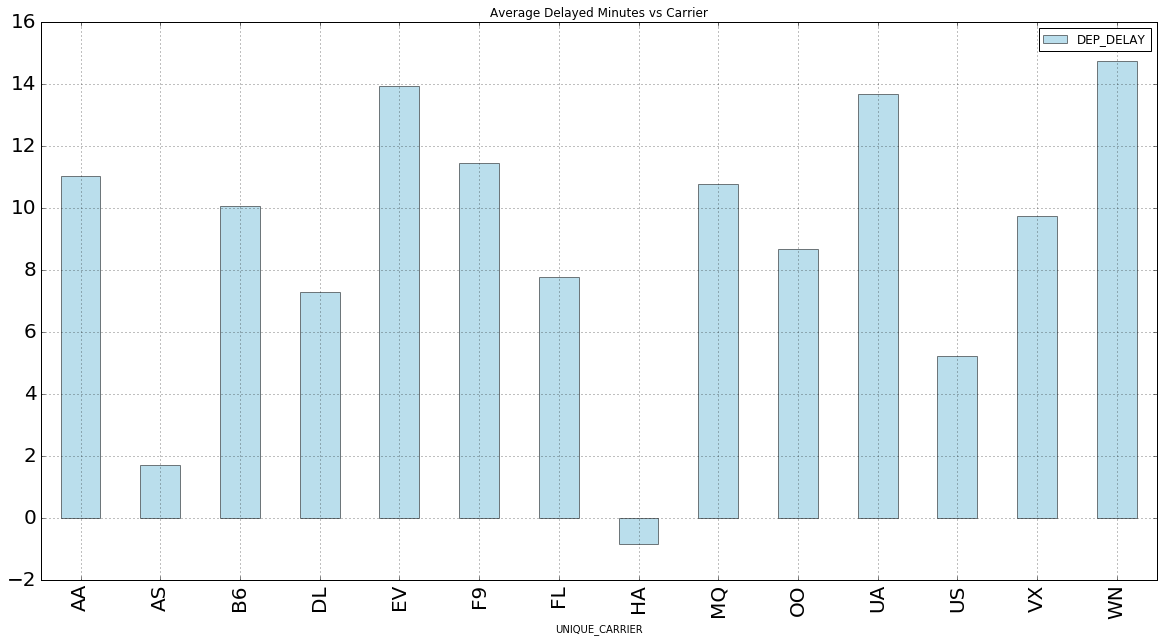

In [32]:
# Compute the average delayed minimutes for each carrier
df_carrierDelMin = df_carrierUpdate.groupby(['UNIQUE_CARRIER'])['DEP_DELAY'].mean().to_frame()
df_carrierDelMin.plot(title='Average Delayed Minutes vs Carrier',\
                      kind='bar',alpha=0.5,grid=True,fontsize =20,color='#77BEDB')

Conclusion: Basically speaking, from the above two plots, we can see that delayed percentage and average delayed minutes are pretty much positive correlated. 

To get a better understanding of delayed minutes against carrier, we can make a box plot

In [33]:
carrier_list = ['AA','AS','B6','DL','EV','F9','FL','HA','MQ','OO','UA','US','VX','WN']
list_df = [df_carrierUpdate[df_carrierUpdate.UNIQUE_CARRIER==carrier][['DEP_DELAY']] \
           for carrier in carrier_list]

In [34]:
for i in range(len(list_df)):
    list_df[i].columns=[carrier_list[i]]

In [35]:
df_describeDelMin = list_df[0].describe()
for i in range(1,14):
    df_describeDelMin=df_describeDelMin.join(list_df[i].describe(),how='inner')

In [36]:
# A table of delayed minutes by carrier
df_describeDelMin

,AA,AS,B6,DL,EV,F9,FL,HA,MQ,OO,UA,US,VX,WN
count,529486.000000,159568.000000,243735.000000,794033.000000,652724.000000,85135.000000,78014.000000,74585.000000,372401.000000,595643.000000,486527.000000,408373.000000,57184.00000,1159661.000000
mean,11.031247,1.725891,10.063897,7.286415,13.955266,11.463957,7.768836,-0.837648,10.783591,8.679259,13.682852,5.234041,9.75731,14.752145
std,45.917284,25.848099,37.246106,35.427582,43.118899,42.666512,29.710272,24.693591,38.853243,34.933664,38.077481,26.972426,36.07148,33.854271
min,-30.000000,-53.000000,-33.000000,-112.000000,-85.000000,-46.000000,-38.000000,-251.000000,-38.000000,-57.000000,-32.000000,-34.000000,-24.00000,-26.000000
25%,-5.000000,-7.000000,-6.000000,-4.000000,-5.000000,-6.000000,-4.000000,-7.000000,-5.000000,-6.000000,-3.000000,-5.000000,-4.00000,-2.000000
50%,-2.000000,-4.000000,-2.000000,-2.000000,-2.000000,-2.000000,-1.000000,-4.000000,-2.000000,-3.000000,1.000000,-3.000000,-1.00000,2.000000
75%,9.000000,1.000000,9.000000,4.000000,13.000000,11.000000,8.000000,-1.000000,11.000000,6.000000,13.000000,3.000000,5.00000,18.000000
max,2402.000000,881.000000,780.000000,1209.000000,907.000000,1092.000000,640.000000,1308.000000,1321.000000,1171.000000,1033.000000,711.000000,481.00000,843.000000


## SECTION II. Analyze Airline Traffic Data on JFK Airport

In [37]:
# Extract data related to the JFK Airport
df_jfk = df_2014[df_2014['ORIGIN']=='JFK'].dropna(subset=['DEP_DELAY'])
df_jfk.head(n=5)

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,TAIL_NUM,...,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2014,1,1,1,3,2014-01-01,AA,19805,AA,N338AA,...,0,385,384,359,2475,NaN,NaN,NaN,NaN,NaN
1,2014,1,1,2,4,2014-01-02,AA,19805,AA,N338AA,...,0,385,389,340,2475,NaN,NaN,NaN,NaN,NaN
3,2014,1,1,4,6,2014-01-04,AA,19805,AA,N327AA,...,0,385,379,346,2475,0,59,0,0,0
4,2014,1,1,5,7,2014-01-05,AA,19805,AA,N323AA,...,0,385,385,347,2475,0,110,0,0,0
5,2014,1,1,6,1,2014-01-06,AA,19805,AA,N319AA,...,0,385,360,323,2475,NaN,NaN,NaN,NaN,NaN


In [38]:
df_jfkHourDpFlt = df_dpHourCount[df_dpHourCount['ORIGIN']=='JFK']
df_jfkHourDpFlt['DP_FLT'] = df_jfkHourDpFlt['DP_FLT']/365

c:\python27\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


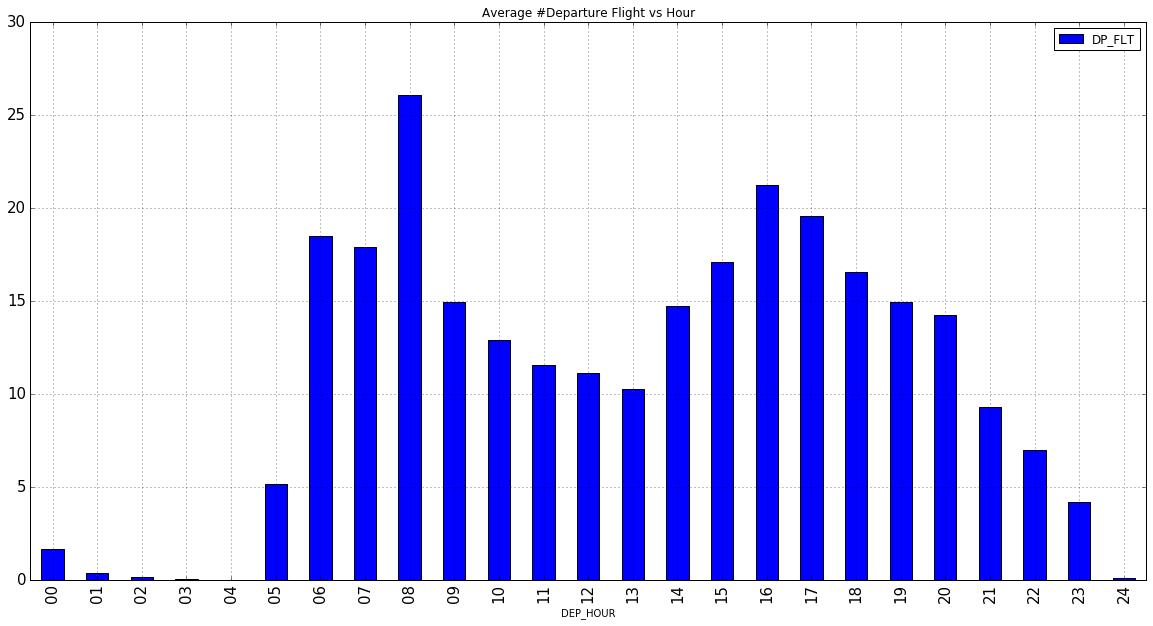

In [39]:
# Plot the number of departure flights by hour 
df_jfkHourDpFlt[['DEP_HOUR','DP_FLT']].plot(kind='bar',x=df_jfkHourDpFlt.DEP_HOUR,grid=True,fontsize=15,title='Average #Departure Flight vs Hour')

c:\python27\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


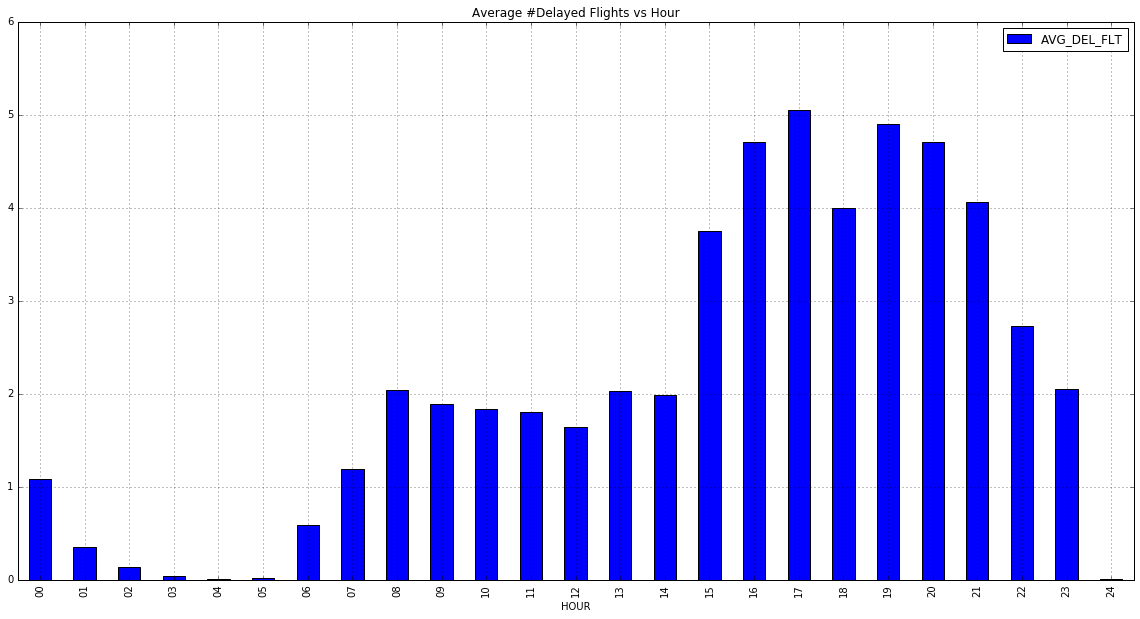

In [40]:
# plot the number of delayed flights by hour
df_jfkDelFlt = df_jfk[['UNIQUE_CARRIER','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','DEP_TIME','DEP_DELAY','DEP_DEL15']]
df_jfkDelFlt['HOUR'] = df_jfk['DEP_TIME'].map(lambda x: str(int(x)).zfill(4)[:2])
df_jfkDelFlt = df_jfkDelFlt[df_jfkDelFlt['DEP_DEL15']==1]
df_jfkDelFltHour = (df_jfkDelFlt.groupby(['HOUR']).size()/365).to_frame().reset_index()
df_jfkDelFltHour.columns = ['HOUR','AVG_DEL_FLT']
df_jfkDelFltHour[['HOUR','AVG_DEL_FLT']].plot(kind='bar',grid=True,x=df_jfkDelFltHour.HOUR,title='Average #Delayed Flights vs Hour')


This is exactly what we expected. The number of delayed flights tend to piled up during the daylight, and start to decline when night comes. 

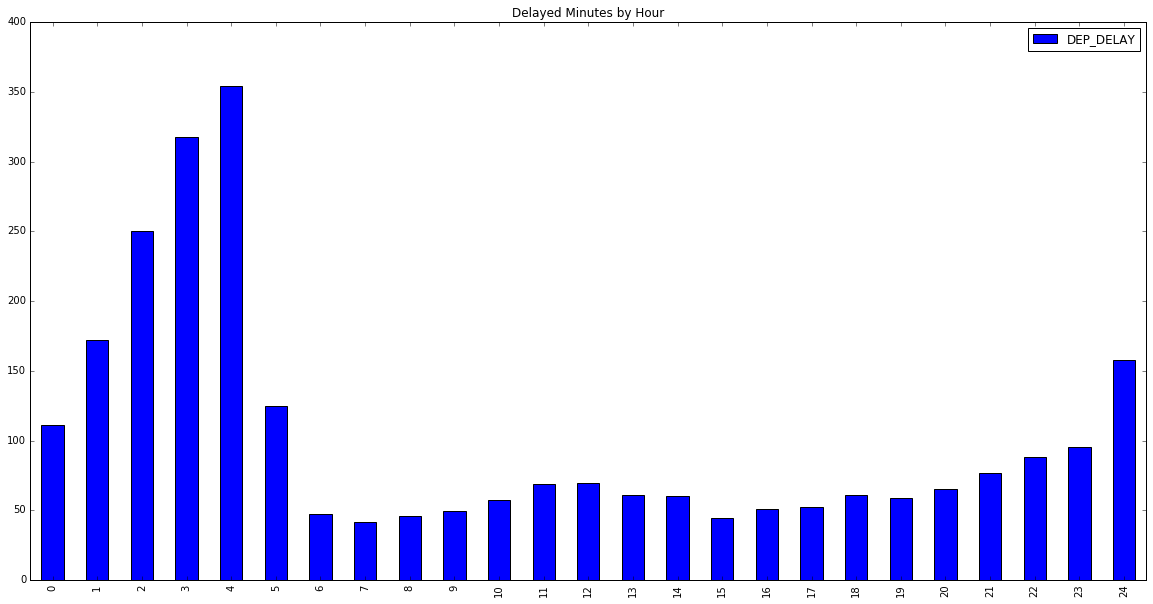

In [41]:
# delayed minutes by hour

df_jfkDelFlt[['DEP_DELAY','HOUR']].groupby(['HOUR']).mean().reset_index().plot(kind='bar',title='Delayed Minutes by Hour')

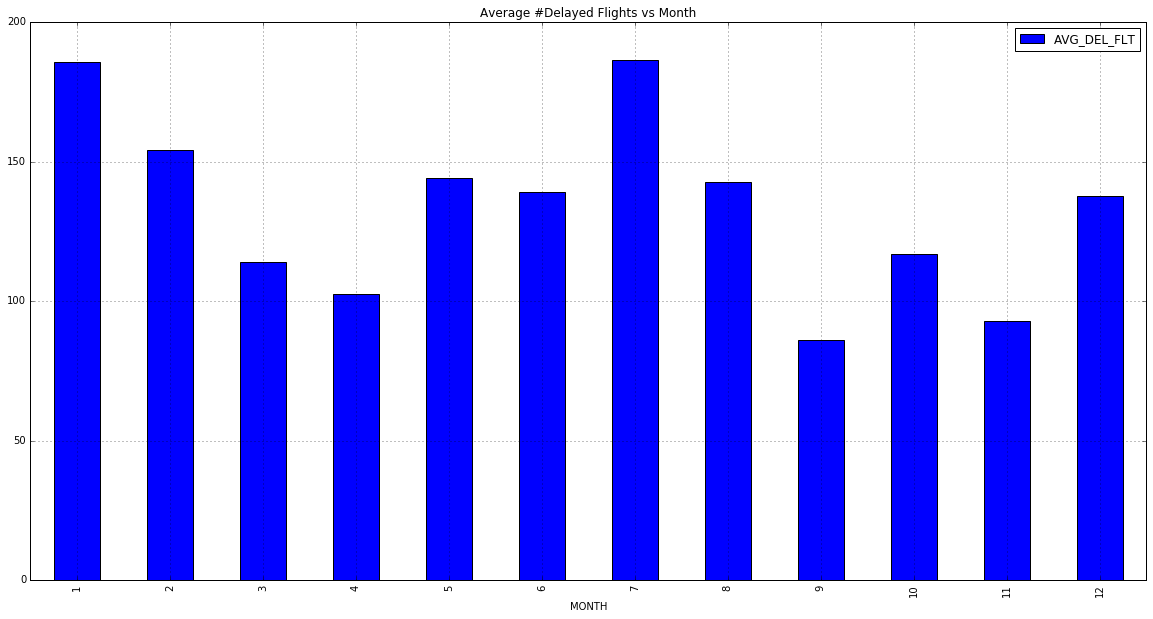

In [42]:
df_jfkDelFltMonth = (df_jfkDelFlt.groupby(['MONTH']).size()/12).to_frame().reset_index()
df_jfkDelFltMonth.columns = ['MONTH','AVG_DEL_FLT']
df_jfkDelFltMonth[['AVG_DEL_FLT']].plot(kind='bar',grid=True,x=df_jfkDelFltMonth.MONTH,title='Average #Delayed Flights vs Month')

## SECTION III. Airline delays prediction
In this Section, we’ll focus on how to build a supervised machine learning model to predict airline delays in JFK airport. We’ll use the 2014 airline traffic data to predict delays in 2015. Note that the latest data is up to Oct, 2015.  Random Forest Classifier is implemented to perform the prediction. The performance is evaluated by the confusion table and prediction accuracy. 
The target variable is a binary value (1 for delays of more than 15 minutes, 0 otherwise). Therefore, there are a lot more 0s than 1s in the target vector Y. I constructed the feature vector x by using the following predictors 
1. Month (winter month tend to have more delays)
2. Day of the month (not so obvious, but let’s keep it)
3. Day of the week (weekdays vs weekends)
4. Carrier (delay situations varies from carriers to carries as shown above.)
5. Destination airport
6. Distance (not so obvious, but it’s interesting to see if it is a good predictor.)
7. The number of days from the nearest holiday (this is based on the assumption that the more close to the holiday, more delays will be.)


### Load and Preprocess the Data

In [43]:
# Load the 2014 airline traffic data
import pandas as pd
import numpy as np

df_flt = pd.read_pickle("flt_2014")

df_fltclean = df_flt.dropna(subset=['DEP_DELAY'])

df_feature1 = df_fltclean[['ORIGIN','YEAR','MONTH','DAY_OF_MONTH','FL_DATE','DAY_OF_WEEK','CARRIER','AIRLINE_ID','DISTANCE','DEST','DEP_DEL15']]
#df_feature1.head()

In [44]:
holidays = [
            datetime(2014, 1, 1), datetime(2014, 1, 20), datetime(2014, 2, 14), datetime(2014, 2, 17), datetime(2014, 4, 13), datetime(2014, 4, 20), \
            datetime(2014, 5, 11), datetime(2014, 5, 26), datetime(2014, 6, 15), datetime(2014, 7, 4), datetime(2014, 9, 1), \
            datetime(2014, 10, 13), datetime(2014, 10, 31), datetime(2014, 11, 11), datetime(2014, 11, 27), datetime(2014, 12, 24), datetime(2014, 12, 25), \
            datetime(2014, 12, 31)
           ]

def days_from_nearest_holiday(flight_date):
    days_list = [abs(flight_date-holiday).days for holiday in holidays]
    return min(days_list)

df_newFeature = df_feature1['FL_DATE'].apply(days_from_nearest_holiday).to_frame()

# merge features
frames = [df_feature1,df_newFeature]
df_mergeFeature2014 = pd.concat(frames,axis=1)
df_mergeFeature2014.columns.values[11]='DAYS_FROM_NEAREST_HOLIDAY'

# extract feature data that origniating from JFK airport
cols = ['YEAR','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','CARRIER','AIRLINE_ID','DISTANCE','DEST','DAYS_FROM_NEAREST_HOLIDAY','DEP_DEL15']
df_JFKFeature2014 = df_mergeFeature2014[df_mergeFeature14['ORIGIN']=='JFK'][cols]

Apply the same procedure to obtain the 2015 feature dataframe.

In [53]:
# Load the 2015 airline traffic feature data
df_2015feature1 = pd.read_pickle('df_2015feature1')

holidays_2015 = [
            datetime(2015, 1, 1), datetime(2015, 1, 19), datetime(2015, 2, 16), datetime(2015, 4, 16), \
            datetime(2015, 5, 10), datetime(2015, 5, 25), datetime(2015, 6, 21), datetime(2015, 7, 3), datetime(2015, 9, 7), \
            datetime(2015, 10, 12), datetime(2015, 11, 11), datetime(2015, 11, 26),datetime(2015, 12, 25)
           ]

def days_from_nearest_holiday2015(flight_date):
    days_list = [abs(flight_date-holiday).days for holiday in holidays_2015]
    return min(days_list)

df_2015newFeature = df_2015feature1['FL_DATE'].apply(days_from_nearest_holiday2015).to_frame()

frames_2015 = [df_2015feature1,df_2015newFeature]
df_mergeFeature2015 = pd.concat(frames_2015,axis=1)

In [55]:
# drop empty items
df_JFKFeature2014 = df_mergeFeature2014[df_mergeFeature2014['ORIGIN']=='JFK'][cols].dropna()
df_JFKFeature2015 = df_mergeFeature2015[df_mergeFeature2015['ORIGIN']=='JFK'][cols].dropna()

In [56]:
df_JFKFeature2014.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CARRIER,AIRLINE_ID,DISTANCE,DEST,DAYS_FROM_NEAREST_HOLIDAY,DEP_DEL15
0,2014,1,1,3,AA,19805,2475,LAX,0,0
1,2014,1,2,4,AA,19805,2475,LAX,1,0
3,2014,1,4,6,AA,19805,2475,LAX,3,1
4,2014,1,5,7,AA,19805,2475,LAX,4,1
5,2014,1,6,1,AA,19805,2475,LAX,5,1


In [57]:
df_JFKFeature2015.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CARRIER,AIRLINE_ID,DISTANCE,DEST,DAYS_FROM_NEAREST_HOLIDAY,DEP_DEL15
0,2015,1,1,4,AA,19805,2475,LAX,0,0
1,2015,1,2,5,AA,19805,2475,LAX,1,0
2,2015,1,3,6,AA,19805,2475,LAX,2,0
3,2015,1,4,7,AA,19805,2475,LAX,3,0
4,2015,1,5,1,AA,19805,2475,LAX,4,0


### Applying supervised machine learning classifier

#### Model 1

In [58]:
from sklearn import cross_validation, metrics,grid_search,svm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder


feature_cols1 = ['MONTH','DAY_OF_MONTH','DAY_OF_WEEK','DISTANCE','DAYS_FROM_NEAREST_HOLIDAY']

train_x1 = df_JFKFeature2014[feature_cols1]
train_y1 = df_JFKFeature2014['DEP_DEL15']
test_x1 = df_JFKFeature2015[feature_cols1]
test_y1 = df_JFKFeature2015['DEP_DEL15']


# Create Random Forest classifier with 25 trees
clf_rf = RandomForestClassifier(n_estimators=25, n_jobs=-1)
clf_rf.fit(train_x1, train_y1)

# Evaluate on test set
pr = clf_rf.predict(test_x1)

# print results
def print_result(test_y,pr):
    cm = confusion_matrix(test_y, pr)
    print("Confusion matrix")
    print(pd.DataFrame(cm))
    report_rf = precision_recall_fscore_support(list(test_y), list(pr), average='micro')
    print "\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
        (report_rf[0], report_rf[1], report_rf[2], accuracy_score(list(test_y), list(pr)))

# print results
print_result(test_y1,pr)

Confusion matrix
        0     1
0  126966  6896
1   32300  2464

precision = 0.26, recall = 0.07, F1 = 0.11, accuracy = 0.77



c:\python27\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


#### Model 2(Encode categorical features)

In [59]:
categ = [cols.index(x) for x in ['CARRIER','AIRLINE_ID','DAY_OF_WEEK','MONTH','DAY_OF_MONTH']]
enc = OneHotEncoder(categorical_features = categ)
feature_cols2 = ['MONTH','DAY_OF_MONTH','DAY_OF_WEEK','CARRIER','AIRLINE_ID','DISTANCE','DEST','DAYS_FROM_NEAREST_HOLIDAY']


df_JFKFeature2014['CARRIER'] = pd.factorize(df_JFKFeature2014['CARRIER'])[0]
df_JFKFeature2014['DEST'] = pd.factorize(df_JFKFeature2014['DEST'])[0]
df_JFKFeature2015['CARRIER'] = pd.factorize(df_JFKFeature2015['CARRIER'])[0]
df_JFKFeature2015['DEST'] = pd.factorize(df_JFKFeature2015['DEST'])[0]

train_x2 = enc.fit_transform(df_JFKFeature2014[feature_cols2])
train_y2 = df_JFKFeature2014['DEP_DEL15']
test_x2 = enc.transform(df_JFKFeature2015[feature_cols2])
test_y2 = df_JFKFeature2015['DEP_DEL15']

In [60]:
# Create Random Forest classifier with 50 trees
clf_rf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
clf_rf.fit(train_x2, train_y2)

# Evaluate on test set
pr3 = clf_rf.predict(test_x2)

# print results
print_result(test_y2,pr3)

Confusion matrix
        0     1
0  131372  2490
1   33668  1096

precision = 0.31, recall = 0.03, F1 = 0.06, accuracy = 0.79



c:\python27\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


From the comparison between the two models, we can see that the accuracy is improved by using the Model 2. 